In [1]:
#@title Setup
import os

# os.chdir(f'/content/OurDDPM')
os.makedirs("checkpoint", exist_ok=True)
os.makedirs("precomputed", exist_ok=True)
os.makedirs("pretrained", exist_ok=True)
os.makedirs("runs", exist_ok=True)
os.makedirs("runs/interpolation", exist_ok=True)

from ourddpm import OurDDPM
from main import dict2namespace
import argparse
import yaml
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

device = 'cuda'

%load_ext autoreload
%autoreload 2

/home/summertony717/anaconda3/envs/python3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import pdb
import cv2
import glob
# from google.colab.patches import cv2_imshow
import pickle
import matplotlib.pyplot as plt
from math import sqrt

model_path = os.path.join("pretrained/celeba_hq.ckpt")

exp_dir = f"runs/guided"
os.makedirs(exp_dir, exist_ok=True)

n_step =  999#@param {type: "integer"}
sampling = "ddpm" #@param ["ddpm", "ddim"]
fixed_xt = True #@param {type: "boolean"}
add_var = True #@param {type: "boolean"}
add_var_on = "0-999" #@param {type: "string"}
vis_gen =  True #@param {type: "boolean"}


args_dic = {
    'config': 'celeba.yml', 
    'n_step': int(n_step), 
    'sample_type': sampling, 
    'eta': 0.0,
    'bs_test': 1, 
    'model_path': model_path, 
    'hybrid_noise': 0, 
    'align_face': 0,
    'image_folder': exp_dir,
    'add_var': bool(add_var),
    'add_var_on': add_var_on
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)


if bool(add_var):
    var_scheduler = []
    periods = add_var_on.split(",")
    for period in periods:
        start = int(period.split("-")[0])
        end = int(period.split("-")[1])
        for n in range(start,end):
            var_scheduler.append(n)

In [3]:
def normalize(img):
    return (img + 1) / 2.0

def fuse_and_display(imgs):
    imgs = [np.array(e) for e in imgs]
    imgs = [normalize(img[0].transpose(1, 2, 0)) for img in imgs]
    display = cv2.hconcat(imgs)
    # display = cv2.cvtColor(display, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 40))
    plt.imshow(display)

def display_img(img):
    img = normalize(img).permute(1, 2, 0)
    plt.figure()
    plt.imshow(img)

In [4]:
if "data_list" not in locals():
    with open("runs/interpolation/data_1.obj","rb") as f:
        data_list = pickle.load(f)


device = torch.device("cuda")
config.device = device
runner = OurDDPM(args, config, device=device)
runner.load_classifier("checkpoint/attr_classifier_makeup_smile_30.pt")

In [8]:

res_list = []
# for i, s in enumerate([1, 2, 3, 4, 5]):
for i, s in enumerate([-200, -100, 0, 100, 200]):
    print(f"Processing {i}th sample...")

    xt = data_list[3]["xt"]
    noise_traj = torch.tensor(data_list[3]["noise_traj"]).cuda()
    img = runner.guided_generate_ddpm(xt, var_scheduler, runner.classifier, 1, classifier_scale=s, noise_traj=noise_traj)

    res_list.append(img.detach().cpu())
    torch.cuda.empty_cache()

with open("runs/guided/data_smile_1.obj", "wb") as f:
    pickle.dump(res_list, f)

Processing 0th sample...
Sampling type: DDPM with eta 0.0,  Steps: 999
Uniform skip type


Generative process: 100%|██████████| 999/999 [01:37<00:00, 10.24it/s]


Processing 1th sample...
Sampling type: DDPM with eta 0.0,  Steps: 999
Uniform skip type


Generative process: 100%|██████████| 999/999 [01:38<00:00, 10.15it/s]


Processing 2th sample...
Sampling type: DDPM with eta 0.0,  Steps: 999
Uniform skip type


Generative process: 100%|██████████| 999/999 [01:38<00:00, 10.16it/s]


Processing 3th sample...
Sampling type: DDPM with eta 0.0,  Steps: 999
Uniform skip type


Generative process: 100%|██████████| 999/999 [01:38<00:00, 10.16it/s]


Processing 4th sample...
Sampling type: DDPM with eta 0.0,  Steps: 999
Uniform skip type


Generative process: 100%|██████████| 999/999 [01:38<00:00, 10.14it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[tensor([[0.7901, 0.0014]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[0.8805, 0.0013]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[0.9957, 0.0085]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[0.9979, 0.9645]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[0.9976, 0.9744]], device='cuda:0', grad_fn=<SigmoidBackward0>)]

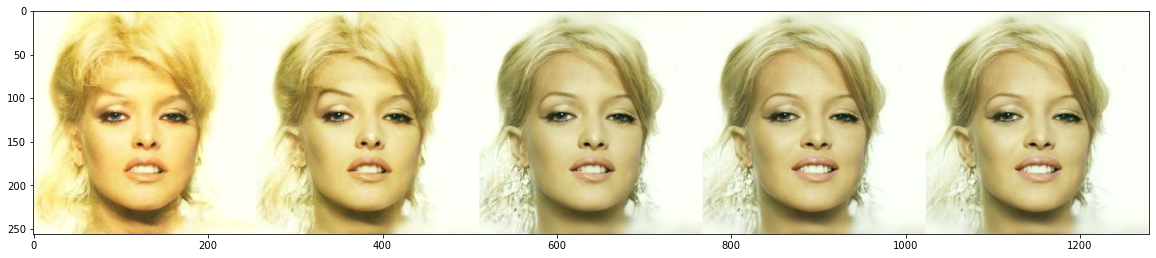

In [9]:
import torch.nn.functional as F

with open("runs/guided/data_smile_1.obj", "rb") as f:
    results = pickle.load(f)
fuse_and_display(results)
classifier_score = []
for each in results:
    t = (torch.ones(1) * 0).cuda()
    classifier_score.append(F.sigmoid(runner.classifier(each.cuda(), t)[:]))
classifier_score

In [10]:
from datasets.data_utils import get_dataset, get_dataloader
data_root = "/home/summertony717/data/celeba_hq"

train_dataset, val_dataset, test_dataset = get_dataset("CelebA_HQ", data_root, config)
i=0

000030.jpg 000030.jpg
tensor([-1, -1])


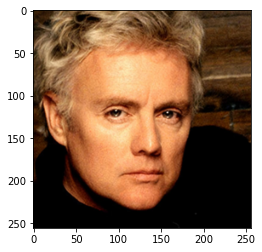

In [16]:
img, label = train_dataset[i]
display_img(img)
print(label)
i+=1

In [5]:
import torch
a = torch.tensor(1.2)
a.item()

1.2000000476837158